In [1]:

# Core
import re

#Data Manipulation 
import pandas as pd
import numpy as np

#Data Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Preprocessing Tools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder


# NLP Tools
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

#Data Evaluation 
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Neural Networks
import tensorflow as tf
import keras
import tensorflow_hub as hub
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping



# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')

In [2]:

import pandas as pd

col_names = [
        'id',               # Column 1: the ID of the statement ([ID].json).
        'label',            # Column 2: the label.
        'statement',        # Column 3: the statement.
        'subjects',         # Column 4: the subject(s).
        'speaker',          # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',       # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        'barely_true', # barely true counts.
        'false', # false counts.
        'half_true', # half true counts.
        'mostly_true', # mostly true counts.
        'pants_on_fire', # pants on fire counts.
        
        'context' # Column 14: the context (venue / location of the speech or statement).
    ]

def read_df(tsv_file: str) -> pd.DataFrame:
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object)
    # replaces all "null" or "NaN" values with an empty string
    df.fillna("", inplace=True)
    # labels the columns in the dataset using the data dictionary described in the README
    df.columns = col_names
    df = df.dropna(subset=["label", "statement"])
    df.drop(["id"], axis=1, inplace=True)
    return df

train_df = read_df('datasets/train.tsv')
test_df = read_df('datasets/test.tsv')
valid_df = read_df('datasets/valid.tsv')


In [3]:

def reset_index(df):
    df = df.reset_index(drop=True)
    return df

def drop_na(df):
    df = df.dropna(subset=['input'], axis=0)
    return df

def drop_duplicated(df):
    df = df.drop_duplicates()
    return df


def label(df):
    df['output'] = df['label'].map({'true': 1,
                                     'mostly-true': 1,
                                     'half-true': 1,
                                     'false': 0,
                                     'barely-true': 0,
                                     'pants-fire': 0}).astype(int)
    return df


def clean_text(text):
    if not isinstance(text, str):
        return ''
    processed_text = text.lower()
    
    processed_text=re.sub(re.compile('[/(){}\[\]\|@,;]'),' ',processed_text)
    processed_text=re.sub(re.compile('[^0-9a-z #+_]'),' ',processed_text)
    
     # Tokenization
    words = word_tokenize(processed_text)
    
    # Lemmatize and stem each word
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stemmed_words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words]
    
    # Stop word removal
    stop_words = set(stopwords.words('english'))
    stop_words.update(['say', 'percent', 'state', 'year', 'said', 'people', 'one'])
    filtered_words = [word for word in stemmed_words if word.lower() not in stop_words]
    # Combine words back into a sentence
    processed_text = ' '.join(filtered_words)
    
    return processed_text

def clean_df(df):
    df['input'] = df['input'].apply(lambda x: clean_text(x))
    return df


In [4]:
cleaning_pipeline = Pipeline(steps=[
    ('drop_na', FunctionTransformer(drop_na)),
    ('drop_duplicated', FunctionTransformer(drop_duplicated)),
    ('label', FunctionTransformer(label)),
    # ('clean', FunctionTransformer(clean_df)),
    ('reset_index', FunctionTransformer(reset_index))
])

In [5]:
x_features = ["statement", "subjects", "speaker", "context", "speaker_job_title", "state_info", 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire']
# x_features = ["statement"]
y_feature = ["output"]


train_df["input"] = train_df[x_features].apply(lambda row: ' '.join(map(str, row)), axis=1)
test_df["input"] = test_df[x_features].apply(lambda row: ' '.join(map(str, row)), axis=1)
valid_df["input"] = valid_df[x_features].apply(lambda row: ' '.join(map(str, row)), axis=1)

# Clean all datasets
train_df = cleaning_pipeline.fit_transform(train_df)
test_df = cleaning_pipeline.transform(test_df)
valid_df = cleaning_pipeline.transform(valid_df)


train_clean_df = train_df[["input", "output"]]
test_clean_df = test_df[["input", "output"]]
valid_clean_df = valid_df[["input", "output"]]


In [6]:
pd.set_option('display.max_colwidth', 500)
train_clean_df.head()


,input,output
0,declin coal start start natur ga took start begin presid georg w bush administr energi histori job accomplish scott surovel floor speech deleg virginia 0 0 1 1 0,1
1,hillari clinton agre john mccain vote give georg bush benefit doubt iran foreign polici barack obama denver presid illinoi 70 71 160 163 9,1
2,health care reform legisl like mandat free sex chang surgeri health care blog post news releas 7 19 3 5 44,0
3,econom turnaround start end term economi job charli crist interview cnn florida 15 9 20 19 2,1
4,chicago bear start quarterback last 10 total number tenur uw faculti fire dure last two decad educ robin vo onlin opinion piec wisconsin assembl speaker wisconsin 0 3 2 5 1,1


In [7]:
# One hot encode y_values
le = LabelEncoder()

train_labels = le.fit_transform(train_clean_df["output"])
val_labels = le.transform(valid_clean_df["output"])
test_labels = le.transform(test_clean_df["output"])

train_labels = np.asarray(to_categorical(train_labels))
val_labels = np.asarray(to_categorical(val_labels))
test_labels = np.asarray(to_categorical(test_labels))

In [8]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2024-01-29 11:23:29.205110: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-29 11:23:29.205135: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-29 11:23:29.205139: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-29 11:23:29.205362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-29 11:23:29.205547: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-01-29 11:23:33.057139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [18]:
# convert sentences to embeddings
X_train = embed(train_clean_df["input"])
X_val = embed(valid_clean_df["input"])
X_test = embed(test_clean_df["input"])

In [19]:
final_model = Sequential()
final_model.add(Dense(units=512, activation="relu"))
final_model.add(Dropout(0.3))
final_model.add(Dense(units=256, activation="relu"))
final_model.add(Dropout(0.3))
final_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
final_model.add(Dropout(0.1))
final_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
final_model.add(Dense(units=2, activation="sigmoid"))

In [21]:
filepath = 'final_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [checkpoint, early_stopping]

final_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00005), metrics=['accuracy'])

history = final_model.fit(X_train, train_labels,
              epochs=300,
              validation_data=(X_val, val_labels),
              batch_size=64,
              verbose=1,
              callbacks=callbacks)

Epoch 1/300
160/160 [==============================] - ETA: 0s - loss: 4.0413 - accuracy: 0.5782
Epoch 1: val_accuracy improved from -inf to 0.55261, saving model to final_model.hdf5
160/160 [==============================] - 6s 31ms/step - loss: 4.0413 - accuracy: 0.5782 - val_loss: 3.6529 - val_accuracy: 0.5526
Epoch 2/300
159/160 [============================>.] - ETA: 0s - loss: 3.3188 - accuracy: 0.5866
Epoch 2: val_accuracy did not improve from 0.55261
160/160 [==============================] - 5s 28ms/step - loss: 3.3169 - accuracy: 0.5868 - val_loss: 3.0206 - val_accuracy: 0.5526
Epoch 3/300
159/160 [============================>.] - ETA: 0s - loss: 2.7575 - accuracy: 0.5907
Epoch 3: val_accuracy improved from 0.55261 to 0.55963, saving model to final_model.hdf5
160/160 [==============================] - 5s 28ms/step - loss: 2.7559 - accuracy: 0.5911 - val_loss: 2.5278 - val_accuracy: 0.5596
Epoch 4/300
159/160 [============================>.] - ETA: 0s - loss: 2.3180 - accurac

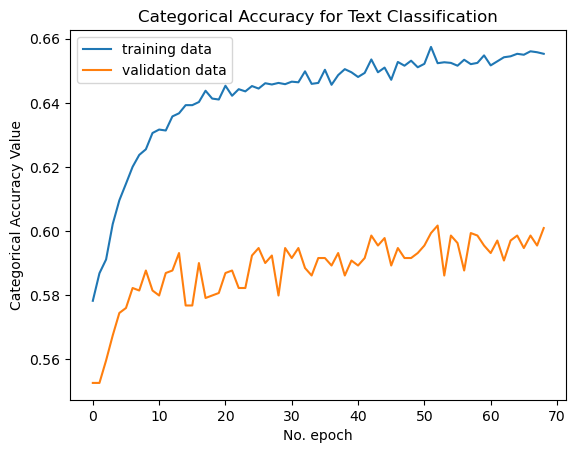

In [22]:
def plot_accuracy(history):
    '''
    Input: Hisotry of Neural Network model
    Prints: Training and validation accuracies
    Output: None
    '''
    plt.plot(history.history['accuracy'], label='training data')
    plt.plot(history.history['val_accuracy'], label='validation data')
    plt.title('Categorical Accuracy for Text Classification')
    plt.ylabel('Categorical Accuracy Value')
    plt.xlabel('No. epoch')
    plt.legend(loc='upper left')
    plt.show()
    return None

plot_accuracy(history)

In [23]:
def evaluate_nn_model(filepath, X, y):
    '''
    Input: hdf5 Model
    Output: Model accuracy
    '''
    model = load_model(filepath)
    yhat = model.predict(X)
    y_pred = [0 if p[0] > 0.5 else 1 for p in yhat]
    y_true = [0 if p[0] > 0.5 else 1 for p in y]
    return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred)

In [24]:
val_acc, val_prec = evaluate_nn_model(filepath, X_val, val_labels)
print(f'Validation Accuracy: {round(val_acc, 4)}')
print(f'Validation Precision: {round(val_prec, 4)}')

41/41 [==============================] - 0s 4ms/step
Validation Accuracy: 0.6025
Validation Precision: 0.5997


In [25]:
test_acc, test_prec = evaluate_nn_model(filepath, X_test, test_labels)
print(f'Test Accuracy: {round(test_acc, 4)}')
print(f'Test Precision: {round(test_prec, 4)}')

40/40 [==============================] - 0s 4ms/step
Test Accuracy: 0.6224
Test Precision: 0.6421


40/40 [==============================] - 0s 3ms/step


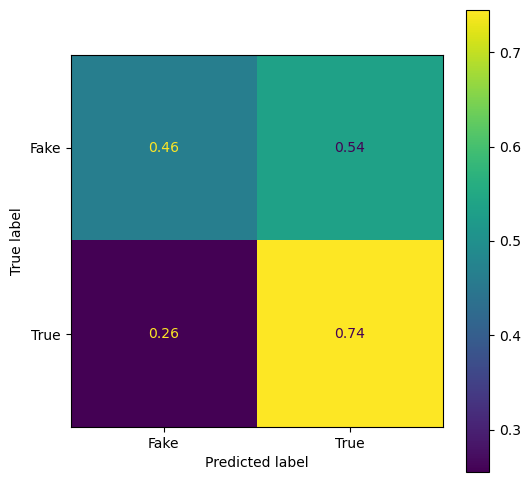

In [26]:
def print_cm_with_labels(y_true, y_pred):
    disp_labels = ['Fake', 'True']
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(disp_labels)
    return None


final_model__ = load_model(filepath)
y_pred = final_model__.predict(X_test)
y_pred =  [0 if p[0] > 0.5 else 1 for p in y_pred]
print_cm_with_labels(test_clean_df["output"], y_pred)